In [110]:
import os
import numpy as np
import pandas as pd
import random
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image

In [3]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

In [92]:
def draw_labels(image, labels_df, thickness, color, fill_poly):
    for row in range(labels_df.shape[0]):
        pts = np.array(labels_df.loc[row]).reshape((-1,1,2))
        if fill_poly:
            image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
        else:
            image = cv.polylines(image, np.int32([pts]), True, color=rgb(color), thickness=thickness)
    
    return image

In [93]:
def rgb(hex_color):
    return tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

In [94]:
thickness = 5
magnet_color = "#00cccc"
tissue_color = "#ff6666"

fill_poly = False

In [4]:
path_img= f"background_1.tiff"
if os.path.isfile(path_img):
    backgnd = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [11]:
path_img= f"data1_cropped/extract/0.tiff"
if os.path.isfile(path_img):
    section = cv.imread(path_img,0)
else:
    print ("The file " + path_img + " does not exist.")

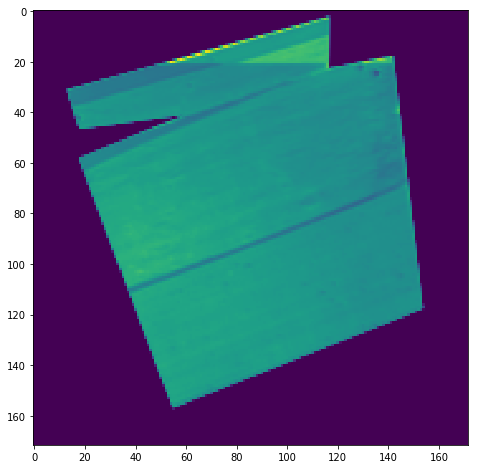

In [57]:
plt.figure(figsize=(10, 8))
plt.imshow(section)

In [25]:
section.shape

(172, 172)

In [ ]:
height_section = section.shape[0]
width_section = section.shape[1]

In [58]:
init_img = np.zeros([height_section,width_section],dtype=np.uint8)
sub = init_img

In [59]:
# Boolean matrix which is true is not 0 (the pixel has a value, and is the potentially the object)
ind_true = section > 0

In [60]:
for i in range(height_section):
    for j in range(width_section):
        if(ind_true[i,j]):
            sub[i,j] = section[i,j]
        else:
            sub[i,j] = 255

In [61]:
for i in range(height_section):
    for j in range(width_section):
        if(sub[i,j] < 25):
            sub[i,j] = 122

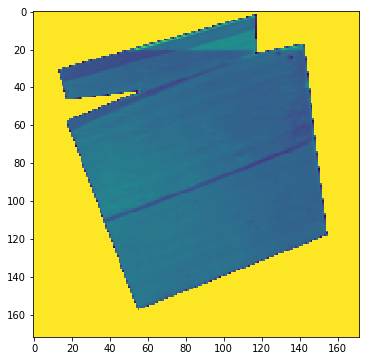

In [62]:
plt.figure(figsize=(8, 6))

plt.imshow(sub)

In [264]:
cv.imwrite("test.tiff", sub)

True

In [64]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

In [77]:
boxes_tissues_dataset1 = pd.read_csv(f"boxes_tissues_1.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_tissues_dataset1.head()

point_1      point_2     point_3     point_4    
        x    y       x   y       x   y       x   y
0      36  110      16  58     142  16     148  67
1      40  114      16  64     141  16     150  65
2      38  110      16  59     143  16     149  66
3      45  126      16  78     132  16     147  66
4      44  123      16  75     136  16     148  65

In [78]:
boxes_mag_dataset1 = pd.read_csv(f"boxes_mag_1.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_mag_dataset1.head()

point_1      point_2      point_3     point_4     
        x    y       x    y       x   y       x    y
0      55  156      37  112     148  68     156  118
1      61  160      42  117     149  67     160  114
2      58  156      39  111     150  67     158  115
3      71  171      46  128     146  66     163  113
4      68  166      44  124     148  66     162  113

In [501]:
def get_collision_boxes(section,nb_boxes = 4, draw = False):
    #Divide the section into 5 block 
    height_section = section.shape[0]
    width_section = section.shape[1]
    
    
    limit_boxes = np.zeros([nb_boxes,4],dtype=np.uint8)
    
    cut_height = height_section//nb_boxes
    for cuts in range(nb_boxes):
        i=0
        
        # y Min
        for i in range(cut_height):
            if( (np.mean( section[i + cuts*cut_height] ) != 0)):
                limit_boxes[cuts,0] = i+cuts*cut_height
                break
        # y Max
        for i in range(cut_height):
            if(np.mean(section[(cuts+1)*cut_height-i-1]) != 0):
                limit_boxes[cuts,1] = (cuts+1)*cut_height-i
                break
        # x Min
        for i in range(width_section):
            if( np.mean( section[ cuts*cut_height+1 : (cuts+1)*cut_height , i] ) != 0):
                limit_boxes[cuts,2] = i
                break
        # x Max
        for i in range(width_section-1,0,-1):
            if(np.mean(section[cuts*cut_height+1:(cuts+1)*cut_height,i]) != 0):
                limit_boxes[cuts,3] = i
                break
        
        
        pts = np.array([limit_boxes[cuts,2],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,1], limit_boxes[cuts,2],limit_boxes[cuts,1] ] )  
        if(draw):
            pts = pts.reshape((-1,1,2))
            section = cv.polylines(section, np.int32([pts]), True, color=rgb(tissue_color), thickness=1)
        
    return limit_boxes
        

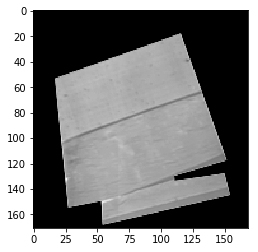

In [542]:
path_img= f"data1_cropped/extract/5.tiff"
section = cv.imread(path_img,0)
plt.imshow(section, cmap='gray')

In [543]:
get_collision_boxes(section,7,True)

array([[ 18,  24, 100, 117],
       [ 24,  48,  33, 126],
       [ 48,  72,  17, 135],
       [ 72,  96,  19, 144],
       [ 96, 120,  21, 152],
       [120, 144,  24, 154],
       [144, 168,  26, 154]], dtype=uint8)

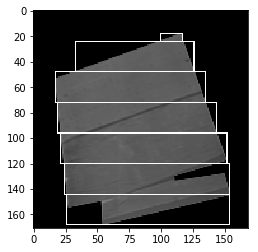

In [544]:
plt.imshow(section, cmap='gray')

In [574]:
full_image = np.zeros([height,width],dtype=np.uint8)
full_image.fill(255)

In [575]:
random.seed(22)

In [576]:
nb_sections = 200

In [577]:
f_seg_tissues_artif = open("seg_tissues_artif_1.txt","w+")
f_seg_mag_artif= open("seg_mag_artif_1.txt","w+")

for index_section in range(nb_sections):
    
    # Section selection
    # section_num will be use to load the data image, and to load the corrects segmentation boxes
    section_num = random.randint(1, 29)
    
    
    path_img= f"data1_cropped/extract/"+str(section_num)+".tiff"
    section = cv.imread(path_img,0)
    height_section = section.shape[0]
    width_section = section.shape[1]
     
    
    xpos_section = random.randint(500, 3500)
    ypos_section = random.randint(500, 2500)
    
    nb_collision_boxes = 6
    collision_boxes_section = get_collision_boxes(section, nb_collision_boxes, False)
    
    free_place = True
    for i in range(nb_collision_boxes):
        # check collision box 1
        if(np.mean(full_image[ypos_section+collision_boxes_section[i][0]:ypos_section+collision_boxes_section[i][1], xpos_section+collision_boxes_section[i][2]:xpos_section+collision_boxes_section[i][3]]) != 255):
            free_place = False

    
    # Find an area in the image free (all pixels = 255)
    timeout = 0

    while(free_place == False):
        xpos_section = random.randint(500, 3500)
        ypos_section = random.randint(500, 2500)
        
        free_place = True
        for i in range(nb_collision_boxes):
            # check collision box 1
            if(np.mean(full_image[ypos_section+collision_boxes_section[i][0]:ypos_section+collision_boxes_section[i][1], xpos_section+collision_boxes_section[i][2]:xpos_section+collision_boxes_section[i][3]]) != 255):
                free_place = False

        if(timeout>10000):
            # end loop no more space
            index_section = nb_sections+1 
            print("No more space")
            break
        else:
            timeout= timeout+1
    
    if(timeout > 10000):
        break
    
    sub = full_image[ypos_section : ypos_section+height_section, xpos_section:xpos_section+width_section]

    # Integrate the section into the full image
    for i in range(height_section):
        for j in range(width_section):
            if(section[i,j] != 0):
                sub[i,j] = section[i,j]

    
    # Smoother border
    for i in range(height_section):
        for j in range(width_section):
            if(sub[i,j] < 25):
                sub[i,j] = 122
    
    #Store the new segmentation position Brain tissues
    temp_tissue = boxes_tissues_dataset1.iloc[section_num]
    
    seg_tissues_p1_x = temp_tissue['point_1']['x'] + xpos_section  
    seg_tissues_p1_y = temp_tissue['point_1']['y'] + ypos_section  
    
    seg_tissues_p2_x = temp_tissue['point_2']['x'] + xpos_section  
    seg_tissues_p2_y = temp_tissue['point_2']['y'] + ypos_section  
    
    seg_tissues_p3_x = temp_tissue['point_3']['x'] + xpos_section  
    seg_tissues_p3_y = temp_tissue['point_3']['y'] + ypos_section 
    
    seg_tissues_p4_x = temp_tissue['point_4']['x'] + xpos_section 
    seg_tissues_p4_y = temp_tissue['point_4']['y'] + ypos_section 
    
    f_seg_tissues_artif.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (seg_tissues_p1_x,seg_tissues_p1_y,  seg_tissues_p2_x,seg_tissues_p2_y,  seg_tissues_p3_x,seg_tissues_p3_y,  seg_tissues_p4_x,seg_tissues_p4_y))
    
    #Store the new segmentation position Mag 
    temp_mag = boxes_mag_dataset1.iloc[section_num]
    
    seg_mag_p1_x = temp_mag['point_1']['x'] + xpos_section  
    seg_mag_p1_y = temp_mag['point_1']['y'] + ypos_section  
    
    seg_mag_p2_x = temp_mag['point_2']['x'] + xpos_section  
    seg_mag_p2_y = temp_mag['point_2']['y'] + ypos_section  
    
    seg_mag_p3_x = temp_mag['point_3']['x'] + xpos_section  
    seg_mag_p3_y = temp_mag['point_3']['y'] + ypos_section 
    
    seg_mag_p4_x = temp_mag['point_4']['x'] + xpos_section 
    seg_mag_p4_y = temp_mag['point_4']['y'] + ypos_section 
    
    f_seg_mag_artif.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (seg_mag_p1_x,seg_mag_p1_y,  seg_mag_p2_x,seg_mag_p2_y,  seg_mag_p3_x,seg_mag_p3_y,  seg_mag_p4_x,seg_mag_p4_y))
    
f_seg_tissues_artif.close()
f_seg_mag_artif.close()

No more space


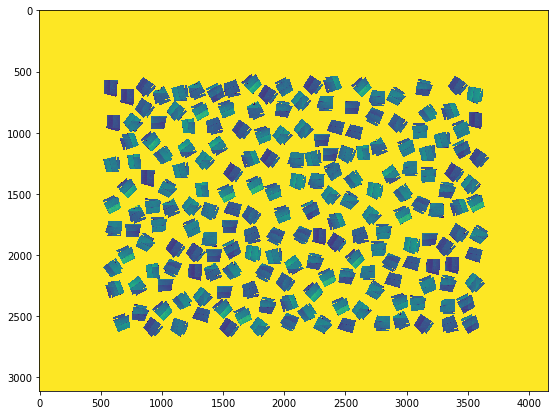

In [578]:
plt.figure(figsize=(15, 7))

plt.imshow(full_image)

In [579]:
cv.imwrite("test_artificial_images.tiff", full_image)

True

In [580]:
width_subbckgnd = backgnd.shape[1]
height_subbckgnd = backgnd.shape[0]

for ind_y in range(10):
    for ind_x in range(10):
        #No objects on the complete background gridcell
        if(np.mean(full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)]) == 255):
            full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd
        
        else:
            for i in range(backgnd.shape[0]):
                for j in range(backgnd.shape[1]):
                    if(full_image[height_subbckgnd*ind_y + i , width_subbckgnd*ind_x + j] == 255):
                        full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd[i,j]
        

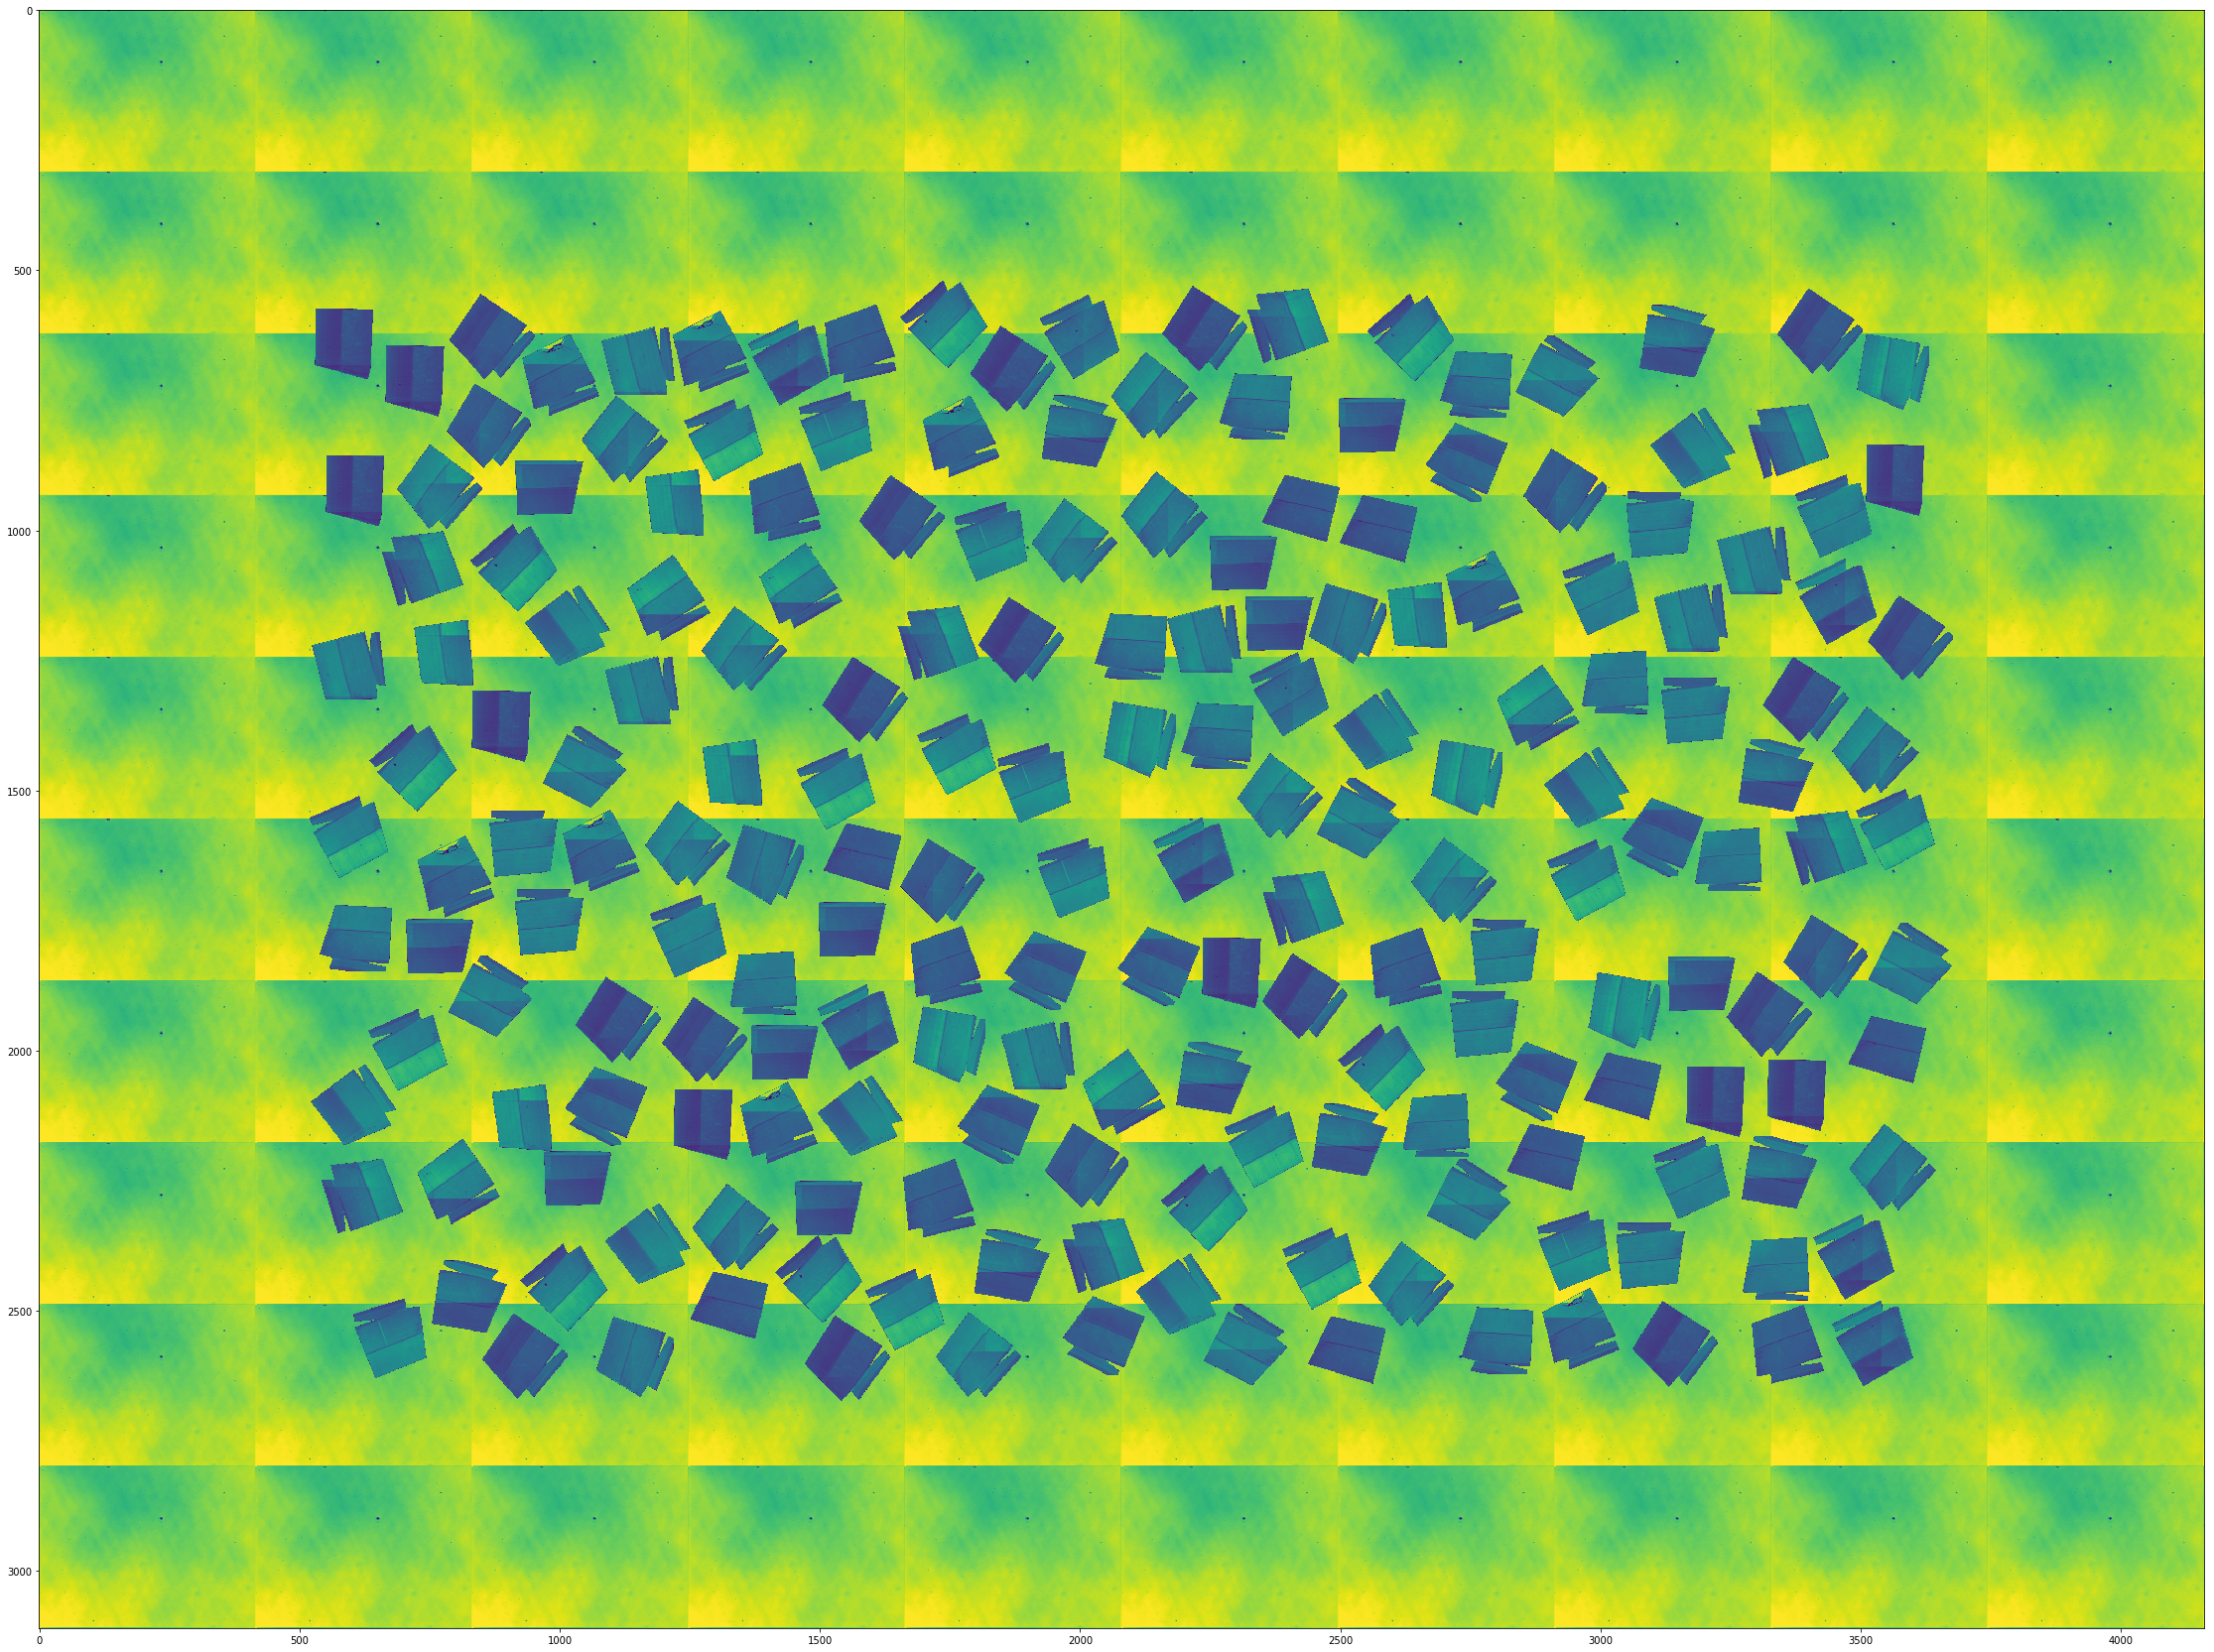

In [581]:
plt.figure(figsize=(40, 30))
plt.imshow(full_image)

In [582]:
cv.imwrite("test2_wthbackground.tiff", full_image)

True

In [583]:
seg_tissues_artif = pd.read_csv(f"seg_tissues_artif_1.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_tissues_artif.head()

point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    1626   612    1646   665    1520   703    1515   652
1    2489   966    2477  1023    2347   985    2372   938
2    1149  2117    1129  2167    1009  2111    1041  2069
3    2030  2165    2078  2195    2004  2305    1969  2267
4     884  1122     842  1081     943   990     970  1033

In [584]:
seg_mag_artif = pd.read_csv(f"seg_mag_artif_1.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_mag_artif.head()

point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    1610   564    1626   611    1515   651    1509   601
1    2500   917    2490   965    2372   939    2393   893
2    1169  2070    1151  2116    1042  2071    1070  2030
3    1987  2139    2028  2166    1968  2266    1931  2231
4     919  1156     885  1122     970  1035     996  1076

In [587]:
path_img= f"test2_wthbackground.tiff"
if os.path.isfile(path_img):
    extrct_img = cv.imread(path_img)
else:
    print ("The file " + path_img + " does not exist.")

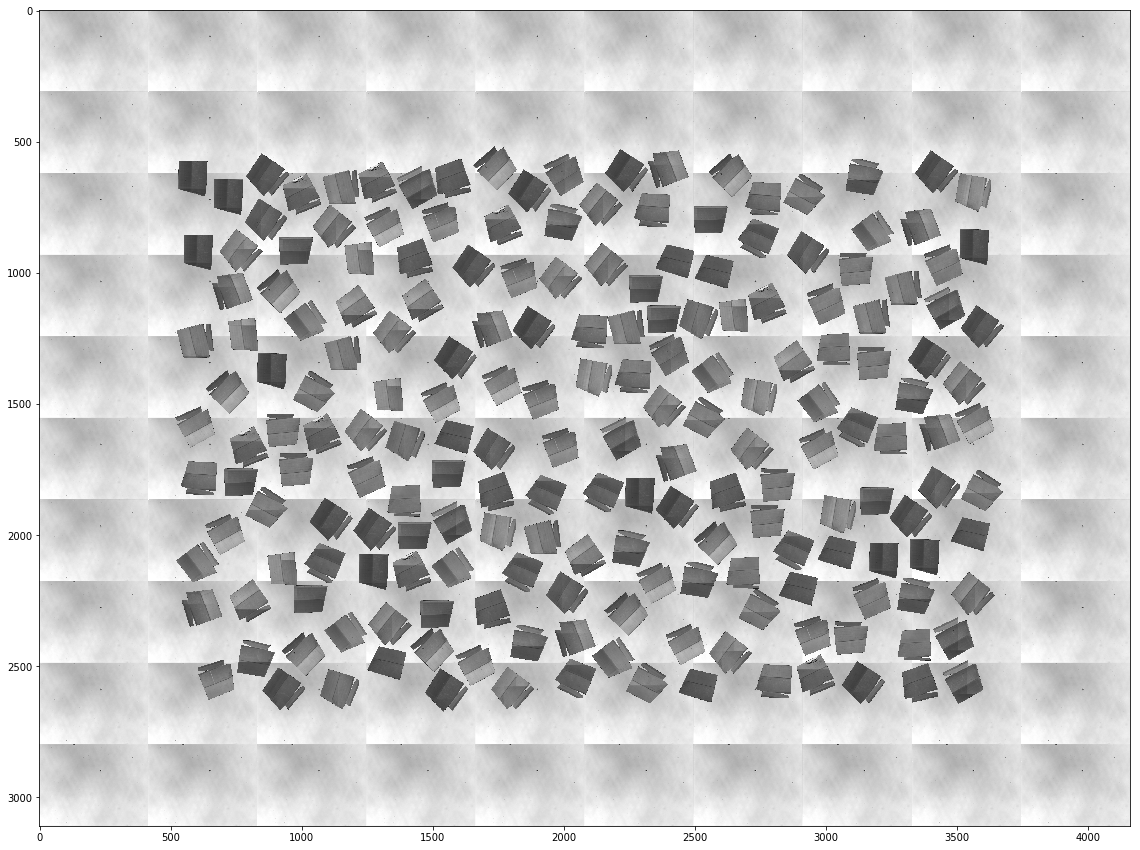

In [589]:
plt.figure(figsize=(20, 15))

plt.imshow(extrct_img)

In [590]:
extrct_img = draw_labels(extrct_img, seg_mag_artif, thickness, magnet_color, fill_poly)

In [591]:
extrct_img = draw_labels(extrct_img, seg_tissues_artif, thickness, tissue_color, fill_poly)

In [596]:
legend_elements = [Line2D([0], [0], color=magnet_color, lw=thickness, label='Magnet Part'),
                       Line2D([0], [0], color=tissue_color, lw=thickness, label='Brain Part')]

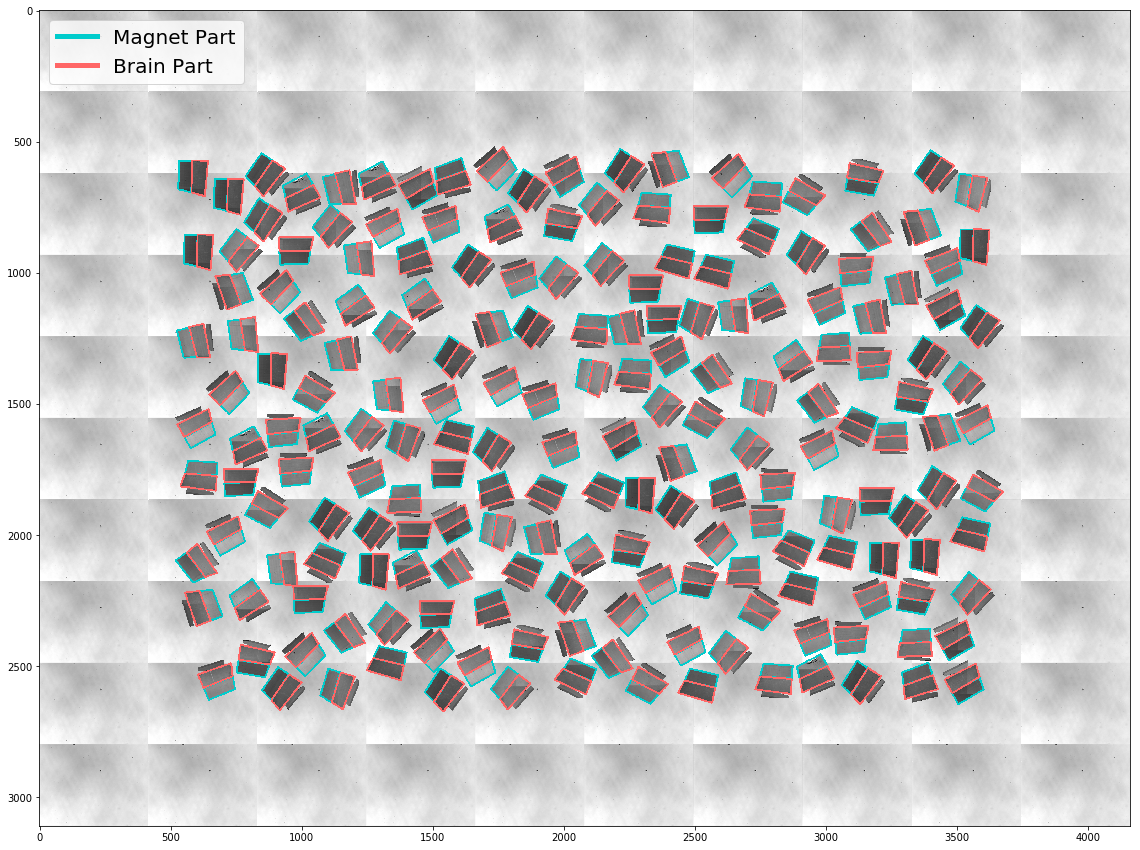

In [597]:
plt.figure(figsize=(20, 15))
plt.imshow(extrct_img)

plt.legend(handles=legend_elements, loc='upper left', fontsize=20)



In [484]:
cv.imwrite("test_artificial_images.tiff", full_image)

True